**First:** Some minor things to set up and use Google Colab directories



# Computational Neuroscience Academy 2023 (Jagiellonian University) [link](https://cna2023.ift.uj.edu.pl/)

[Workshops](https://cna2023.ift.uj.edu.pl/workshops)



In [26]:
from google.colab import files
from google.colab import drive
import os
import sys
drive.mount('/content/gdrive', force_remount=True)
sys.path.append('/content/gdrive/My Drive/Neuro-Academy-Poland')

Mounted at /content/gdrive


# Parametrization and RNN Traning


**1)** **Decision-making task (Temporal "And")**

The provided code defines a function called generate_trials that generates trial data for an And dataset training task. It sets up various parameters such as stimulus duration, noise level, variable delay length, and sample size. The function generates input sequences (x_train) and output sequences (y_train) based on randomly selected trial types and variable delays. It also creates a mask to indicate relevant time steps for each trial. The function adds random noise to the input sequences and calculates the time taken to generate the dataset. Finally, it returns the generated data, including the input sequences, output sequences, mask, and total sequence duration.

Task From:

[Effect in the spectra of eigenvalues and dynamics of RNNs trained with Excitatory-Inhibitory constraint](https://doi.org/10.1007/s11571-023-09956-w )

[Different eigenvalue distributions encode the same temporal tasks in recurrent neural networks](https://doi.org/10.1007/s11571-023-09956-w )

[Multitasking in RNN: an analysis exploring the combination of simple tasks](https://iopscience.iop.org/article/10.1088/2632-072X/abdee3)


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import time
from numpy.random import seed

start_time  = time.time()
seed_choice = 2
seed(seed_choice)

def generate_trials(size, mem_gap):
    seed(3)

    first_in         = 60   # to start the first stimulus
    stim_dur         = 20   # stimulus duration
    stim_noise       = 0.1  # noise level
    var_delay_length = 50   # for a variable starting point of the stimuli
    out_gap          = 140  # how much lenth add to the sequence duration
    sample_size      = size # sample size


    and_seed_A = 1*np.array([[0],[1],[0],[1]])
    and_seed_B = 1*np.array([[0],[0],[1],[1]])
    and_y      = 1* np.array([0,0,0,1])
    seq_dur    = first_in+stim_dur+mem_gap+var_delay_length+out_gap #Sequence duration

    if var_delay_length == 0:
        var_delay = np.zeros(sample_size, dtype=np.int)
    else:
        var_delay = np.random.randint(var_delay_length, size=sample_size) + 1
    second_in = first_in + stim_dur + mem_gap


    out_t       = mem_gap+ first_in+stim_dur
    trial_types = np.random.randint(4, size=sample_size)
    x_train     = np.zeros((sample_size, seq_dur, 2))
    x_train_    = np.zeros((sample_size, seq_dur, 2))
    y_train     =  np.zeros((sample_size, seq_dur, 1))

    for ii in np.arange(sample_size):
        x_train[ii, first_in+var_delay[ii]:first_in + stim_dur+var_delay[ii], 0] = and_seed_A[trial_types[ii], 0]
        x_train[ii, first_in+var_delay[ii]:first_in + stim_dur+var_delay[ii], 1] = and_seed_B[trial_types[ii], 0]

        y_train[ii, out_t + var_delay[ii]:, 0] = and_y[trial_types[ii]]

    mask = np.zeros((sample_size, seq_dur))
    for sample in np.arange(sample_size):
        mask[sample,:] = [1 for y in y_train[sample,:,:]]

    x_train = x_train +stim_noise * np.random.randn(sample_size, seq_dur, 2)
    print("--- %s seconds to generate And dataset---" % (time.time() - start_time))
    return (x_train, y_train, mask,seq_dur)


**2)** Lets take a look on the task parametrization and training dataset:

--- 23.360410928726196 seconds to generate And dataset---


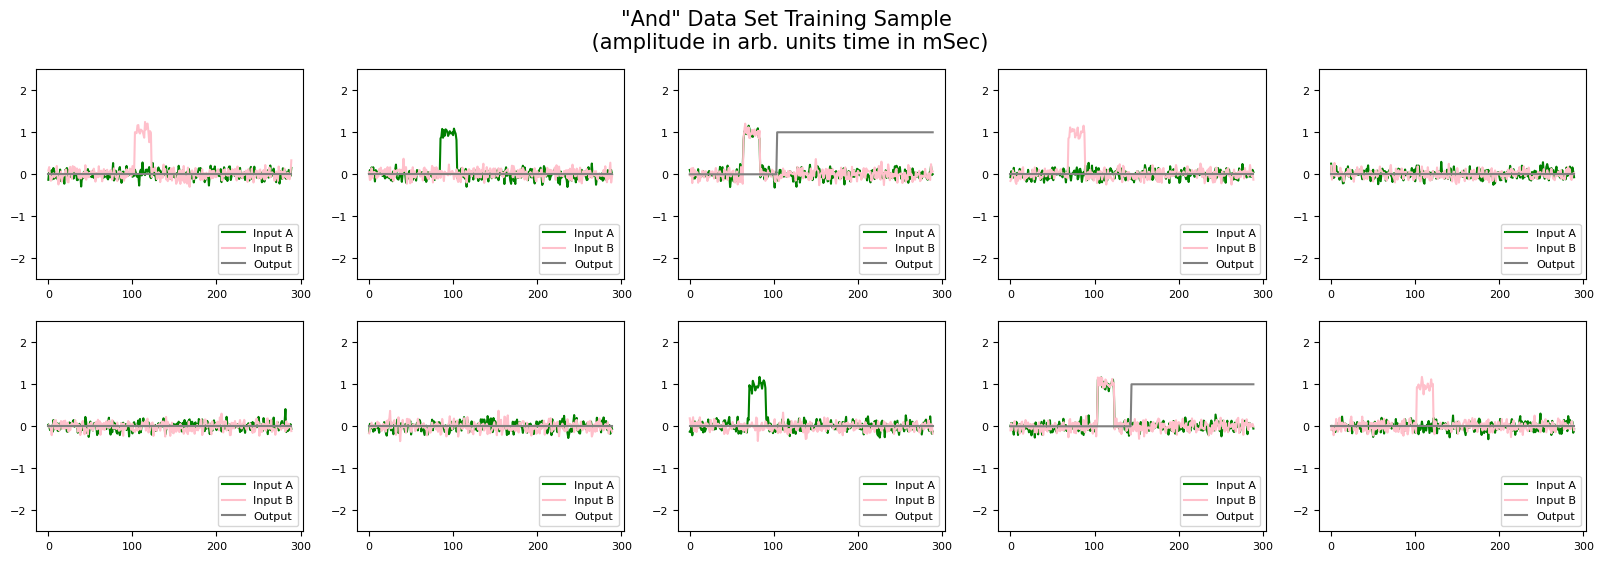

In [15]:
sample_size = 10
mem_gap     = 20
x_train,y_train, mask,seq_dur = generate_trials(sample_size,mem_gap)

fig     = plt.figure(figsize=(20,6))
fig.suptitle("\"And\" Data Set Training Sample\n (amplitude in arb. units time in time steps)",fontsize = 15)
for ii in np.arange(10):
    plt.subplot(2, 5, ii + 1)
    plt.plot(x_train[ii, :, 0],color='g',label="Input A")
    plt.plot(x_train[ii, :, 1],color='pink',label="Input B")
    plt.plot(y_train[ii, :, 0],color='grey',label="Output")
    plt.ylim([-2.5, 2.5])
    plt.legend(fontsize= 8,loc=4)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
figname = "data_set_and_sample_seed_"+str(seed_choice)+".png"
#figname = base+"/data_set_and_sample.png"
plt.savefig(figname,dpi=200)
plt.show()

**3)** Now we import all necesary libraries for [keras/tensorflow](https://www.tensorflow.org/guide/keras/working_with_rnns)

In [16]:
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, Callback
from keras.layers import TimeDistributed, Dense, Activation, Dropout,SimpleRNN
from keras.utils import plot_model
from keras import metrics, optimizers, regularizers,  Input


**4) RNN Definition and training**

The following code defines a function named and_train_rnn. This function is responsible for training and testing a recurrent neural network (RNN) on an "And" task using the dataset parametrization. It starts by generating trial data using the generate_trials function. Then, it builds an RNN model using the Sequential API from Keras, adds layers to the model, and saves the initial model weights. The model is compiled with an optimizer and loss function. Training is performed using the fit method, and early stopping is applied based on the loss value using the EarlyStoppingByLossVal callback. After training, the function tests the model on a subset of the data and visualizes the input, desired output, and predicted output for a few samples. Finally, it saves the model summary, plots the model architecture, and plots the loss history during training.

This code includes a class called EarlyStoppingByLossVal, which is a callback function used for early stopping during the training of a neural network.

In [42]:
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.000001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value   = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print(" Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

def and_train_rnn(t,N_rec,epochs,base,base_plot):

    #Parameters
    sample_size                   = 15050
    #epochs                        = 20
    x_train,y_train, mask,seq_dur = generate_trials(sample_size,mem_gap)

    #Network model
    seed(None) #
    model = Sequential()
    model.add(SimpleRNN(units=N_rec,return_sequences=True, input_shape=(None, 2), kernel_initializer='glorot_uniform',recurrent_initializer= 'orthogonal',use_bias=False))
    model.add(Dense(units=1,input_dim=N_rec))
    model.save(base+'/'+base_plot[-4]+base_plot[-3]+'_00_initial.hdf5')


    # Model Compiling:
    ADAM               = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999,epsilon=1e-08, decay=0.0001)
    model.compile(loss = 'mse', optimizer=ADAM, sample_weight_mode="temporal")

    # Saving weigths:
    filepath       = base+'/and_weights-{epoch:02d}.hdf5'
    callbacks      = [EarlyStoppingByLossVal(monitor='loss', value=0.00005, verbose=1), ModelCheckpoint(filepath, monitor='val_loss', save_best_only=False, verbose=1),]
    history        = model.fit(x_train[50:sample_size,:,:], y_train[50:sample_size,:,:], epochs=epochs, batch_size=64, callbacks = callbacks,     sample_weight=mask[50:sample_size,:])


    # Model Testing:
    x_pred = x_train[0:50,:,:]
    y_pred = model.predict(x_pred)

    print("x_train shape:\n",x_train.shape)
    print("x_pred shape\n",x_pred.shape)
    print("y_train shape\n",y_train.shape)

    fig     = plt.figure(figsize=(20,6))
    fig.suptitle("\"And\" Data Set Trainined Output \n (amplitude in arb. units time in time steps)",fontsize = 20)
    for ii in np.arange(10):
        plt.subplot(2, 5, ii + 1)
        plt.plot(x_train[ii, :, 0],color='g',label="input A")
        plt.plot(x_train[ii, :, 1],color='pink',label="input B")
        plt.plot(y_train[ii, :, 0],color='grey',linewidth=3,label="Expected output")
        plt.plot(y_pred[ii, :, 0], color='r',label="Predicted Output")
        plt.ylim([-2.5, 2.5])
        plt.legend(fontsize= 5,loc=3)
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        figname =  base_plot+"/data_set_sample_trained.png"
        plt.savefig(figname,dpi=200)
    plt.show()
    plt.close(fig)


    print(model.summary())
    plot_model(model, to_file='model.png')
    plt.show()

    print ("history keys",(history.history.keys()))

    fig     = plt.figure(figsize=(8,6))
    plt.grid(True)
    plt.plot(history.history['loss'])
    plt.title('Model loss during training')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    figname = base_plot+"/model_loss_"+str(N_rec)+".png"
    plt.savefig(figname,dpi=200)
    plt.show()
    plt.close(fig)

5) We call al defined function to trian some networks: ( here I will train only one, but it is possible to change it with the "for" range)

This code sets up a loop that iterates once over a range from 0 to x. Within each iteration, it assigns the values for mem_gap and N_rec variables and constructs directory paths based on those values. It then checks if the directories specified by the paths exist and creates them if they don't. The function and_train_rnn is called with the assigned values, and this process repeats for each iteration to obtain as many trained networks as we wanted.,


/content/gdrive/My Drive/Neuro-Academy-Poland/weights/weights_N_50_gap_0
/content/gdrive/My Drive/Neuro-Academy-Poland/plots/plots_N_0


--- 6228.977550983429 seconds to generate And dataset---
Epoch 1/20
234/235 [============================>.] - ETA: 0s - loss: 0.0800
Epoch 1: saving model to /content/gdrive/My Drive/Neuro-Academy-Poland/weights/weights_N_50_gap_0/and_weights-01.hdf5
235/235 [==============================] - 19s 75ms/step - loss: 0.0799
Epoch 2/20
235/235 [==============================] - ETA: 0s - loss: 0.0074
Epoch 2: saving model to /content/gdrive/My Drive/Neuro-Academy-Poland/weights/weights_N_50_gap_0/and_weights-02.hdf5
235/235 [==============================] - 19s 79ms/step - loss: 0.0074
Epoch 3/20
235/235 [==============================] - ETA: 0s - loss: 0.0070
Epoch 3: saving model to /content/gdrive/My Drive/Neuro-Academy-Poland/weights/weights_N_50_gap_0/and_weights-03.hdf5
235/235 [==============================] - 18s 79ms/step - loss: 0.0070
Epoch 4/20
235/235 [==============================] - ETA: 0s - loss: 0.0042
Epoch 4: saving model to /content/gdrive/My Drive/Neuro-Academy-P

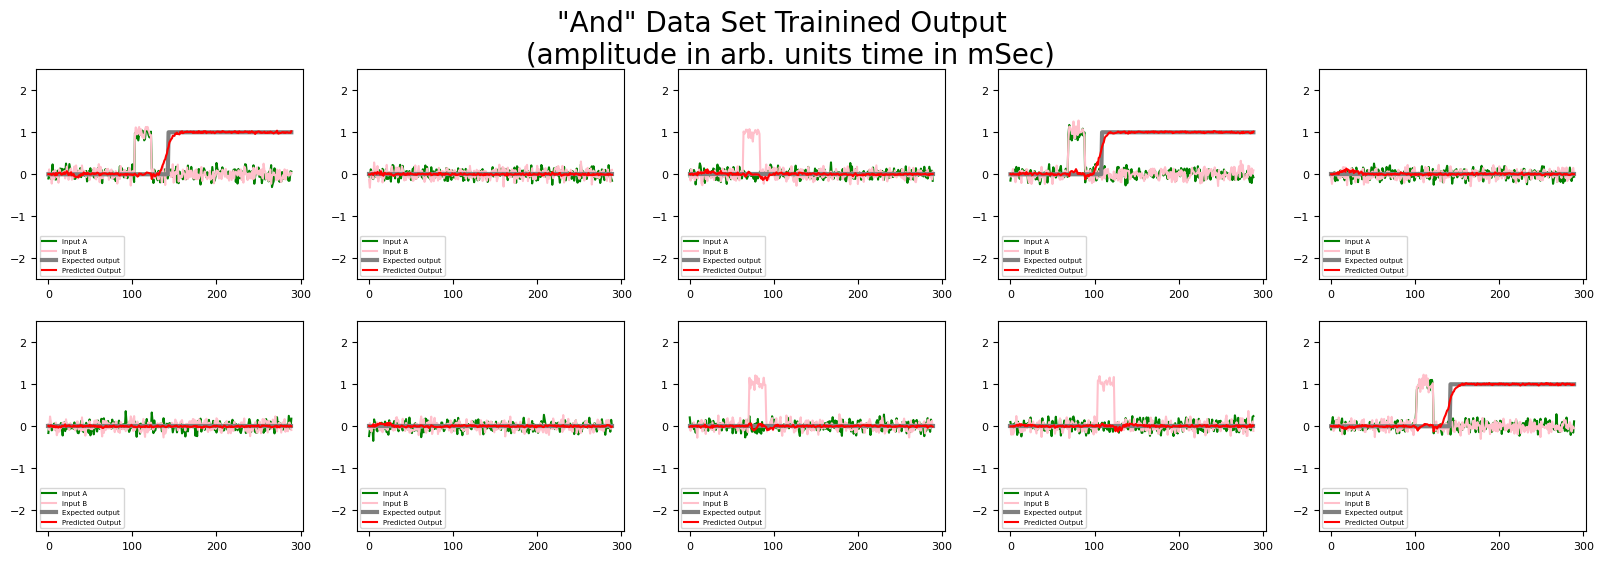

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, None, 50)          2600      
                                                                 
 dense_4 (Dense)             (None, None, 1)           51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________
None
history keys dict_keys(['loss'])


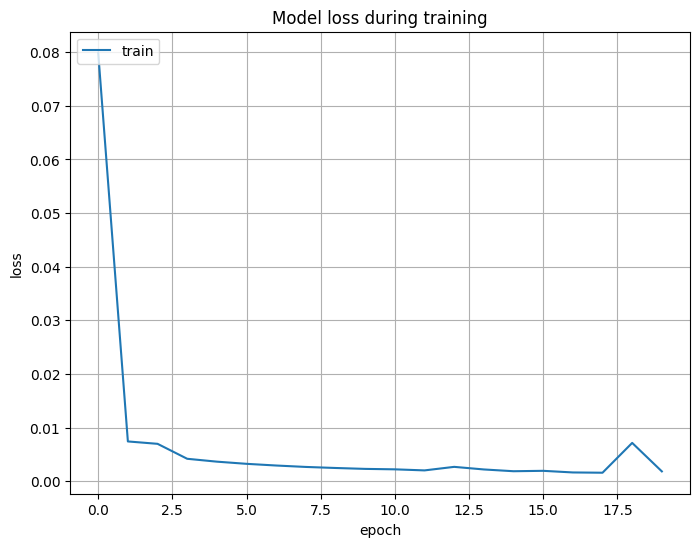

-------------------------
--- 6688.292033910751 to train the network seconds ---


In [43]:
f          ='/content/gdrive/My Drive/Neuro-Academy-Poland/weights'
f_plot     ='/content/gdrive/My Drive/Neuro-Academy-Poland/plots'

for i in np.arange(0,1,1):
    mem_gap  = 20
    N_rec    = 50
    base     = f+'/'+  os.path.basename(f+'_'+'N_'+str(N_rec)+'_gap_'+str(i))
    base_plot= f_plot+'/'+  os.path.basename(f_plot+'_'+'N_'+str(i))

    dir = str(base)
    if not os.path.exists(dir):
        os.mkdir(base)
    print(str(dir))
    dir = str(base_plot)
    if not os.path.exists(dir):
        os.mkdir(base_plot)
    print(str(dir))

    pepe    =and_train_rnn(mem_gap,N_rec,20,base, base_plot)

print('-------------------------')
print("--- %s to train the network seconds ---" % (time.time() - start_time))

# Some questions about the code:

1. What is the purpose of the `EarlyStoppingByLossVal` class in the code?
2. How is the neural network model constructed in the `and_train_rnn` function?
3. What optimizer is used for compiling the model and what are its parameters?
4. What are the callbacks used during the training process?
5. How is the loss calculated and optimized during training?
6. What are the dimensions of the `x_train`, `x_pred`, and `y_train` arrays?
7. How many connection parameters does the model have?